# 결정트리

결정트리는 SVM 처럼 분류와 회귀 작업 그리고 다중출력 작업도 가능한 다재다능한 머신.

심지어 매우 복잡한 데이터셋도 학습할 수 있는 강력한 알고리즘.

이번 장에서는 결정트리의 훈련, 시각화, 예측방법에 대해 먼저 살펴볼 겁니다.

그다음 사이킷런의 CART 훈련 알고리즘을 둘러보고 트리에 규제를 가하는 방법과 

회귀문제에 적용하는 방법을 배우고, 마지막에는 결정트리의 제약사항에 관해 얘기해보겠습니다.

## 결정 트리 학습과 시각화

In [223]:
import sys
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

우선 결정 트리를 이해하기 전에 어떻게 예측하는지 봅시다. 다음 붓꽃데이터셋을 사용함(4장 참조)

In [224]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # 꽃잎 길이와 너비
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

export_graphviz() 를 사용해 그래프 정의를 iris_tree.dot 파일로 출력하여 훈련된 결정트리 시각화 가능.

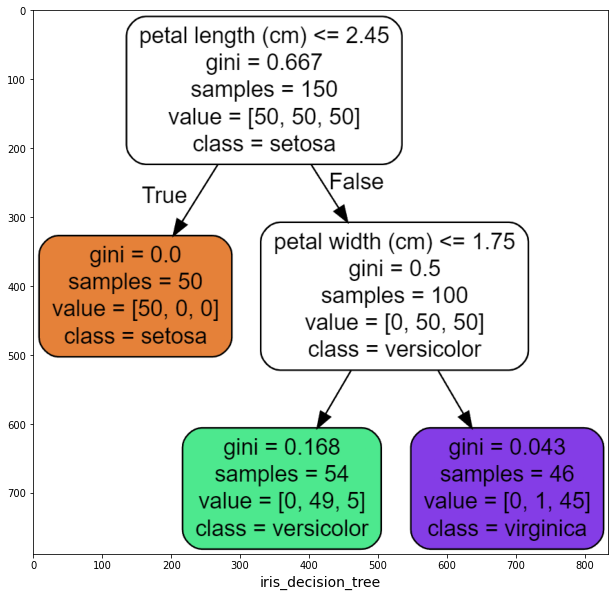

In [225]:
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

# Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))
# dot 파일로 들어가서 ctrl + shift + v 하면 preview 형태로 볼 수 있음

# 책에 있는 내용과는 좀 다름

import matplotlib.image as mpimg

filename = "[6-1] iris_tree.png"
images_path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
show_img = mpimg.imread(os.path.join(images_path, filename))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.imshow(show_img)

## 예측하기

위의 그림의 트리가 어떻게 예측을 만들어내는지 살펴봅시다.

새로 발견한 붓꽃의 품종을 분류하려 한다고 가정. 

먼저 루트노드(깊이 0인 꼭대기 노드) 이 노드는 꽃잎의 길이가 2.45cm보다 짧은지 검사. 

만약 그렇다면 루트 노드에서 왼쪽의 자식노드(왼쪽노드, 깊이 1)로 이동. 

이 경우 이 노드가 리프 노드(자식노드를 가지지 않는 노드)이므로

추가적인 검사를 하지 않습니다. 그냥 노드에 있는 예측 클래스를 보고 결정트리가 새로 발견한 꽃의 품종을

Iris-Setosa (class= setosa)라고 예측.

또 다른 꽃을 발견했는데 이번에는 꽃잎의 길이가 2.45cm 보다 김.

이번에는 루트노드의 오른쪽 자식노드로 이동해야 함. 이 노드는 리프노드가 아니라

추가로 '꽃잎의 너비가 1.75cm보다 작은지' 검사. 

만약 그렇다면 이 꽃은 아마도 Iris-Versicolor(깊이 2, 왼쪽) 일 것.

그렇지 않다면 Iris-Virginica(깊이 2, 오른쪽) 일 것.

#### NOTE_ 

결정트리의 장점 중 하나는 전처리가 거의 필요하지 않음.

사실 특성 스케일을 맞추거나 평균을 원점에 맞추는 직업이 필요하지 않습니다.

노드의 sample 속성은 얼마나 많은 훈련 샘플이 적용되었는지 헤아린 것.

예를 들어 100개의 훈련샘플의 꽃잎 길이가 2.45cm보다 길고(깊이 1, 오른쪽),

그중 54개 샘플의 꽃잎 너비가 1.75cm보다 짧습니다(깊이 2, 왼쪽).

노드의 value 속성은 노드에서 각 클래스에 얼마나 많은 훈련 샘플이 있는지 알려줌.

|

예를 들어 맨 오른쪽 아래 노드는 Iris-Setosa가 0개, Iris-Versicolor가 1개,

Iris-Virginica가 45개 있음. 마지막으로 노드의 gini 속성은 불순도를 측정함.

한 노드의 모든 샘플이 같은 클래스에 속해 있다면 이 노드를 순수(gini=0)하다고 함.

|

예를 들어 깊이 1의 왼쪽 노드는 Iris-Setosa 훈련 샘플만 가지고 있으므로 순수 노드이고

gini=0 임. [식 6-1]은 훈련 알고리즘이 i번째 노드의 gini 점수가 $G_i$ 를 계산하는 방법을 보여줌.

깊이 2의 왼쪽노드의 gini 점수는 $1-(0/54)^2-(49/54)^2-(5/54)^2 \approx 0.168 $

**식 6-1: 지니 불순도**

$
G_i = 1 - \sum\limits_{k=1}^{n}{{p_{i,k}}^2}
$

* 이 식에서 $p_{i,k}$ 는 i번째 노드에 있는 훈련샘플 중 클래스 $k$ 에 속한 샘플의 비율.

#### NOTE_

사이킷런은 이진트리만 만드는 CART 알고리즘을 사용함. 그러므로 리프노드 외의 모든노드는 자식노드를

2개씩 가짐.(즉, 질문의 답은 '예'나 '아니오') 

하지만 ID3 같은 알고리즘은 둘 이상의 자식노드를 가진 결정트리를 만들수 있음.

[6-2]는 이 결정트리의 결정경계를 보여줌. 굵은 수직선이 루트노드의 결정경계를 나타냄.

왼쪽 영역은 순수노드(Iris-Setosa만 있음)이기 때문에 더는 나눌 수 없음.

하지만 오른쪽 영역은 순수노드가 아니므로 깊이 1의 오른쪽노드는 꽃잎너비 = 1.75cm에서 나뉨.

max_depth를 2로 설정했기 때문에 결정트리는 더 분할되지 않았음.

max_depth를 3으로 하면 깊이 2의 두 노드가 각각 결정경계를 추가로 만듦(점선)

그림 저장: [6-2] decision_tree_decision_boundaries_plot


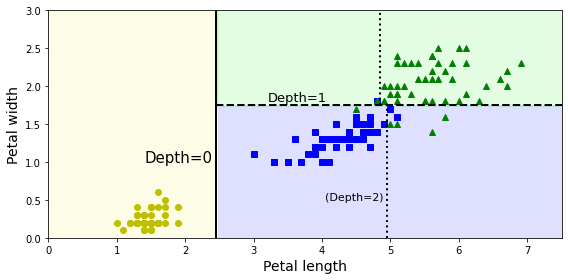

In [226]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

save_fig("[6-2] decision_tree_decision_boundaries_plot")
plt.show()

## 클래스 확률 추정

결정트리는 한 샘플이 특정 클래스 k에 속할 확률을 추정할 수도 있음.

트리를 탐색하고 그 노드에 있는 클래스 k의 훈련 샘플의 비율을 반환합니다.

|

예를 들어 길이 5cm, 너비 1.5cm인 꽃잎을 발견했다고 가정하면

이 해당되는 리프노드는 깊이 2에서 왼쪽 노드이므로 결정트리는 그에 해당하는 확률을 출력

즉, Iris-Setosa는 0%(0/54), Iris-Versicolor는 90.7%(49/54), Iris-Verginica는 9.3%(5/54)

만약 클래스를 하나 예측한다면 가장 높은 확률을 가진 Iris-Verginica(클래스 1)를 출력.

In [227]:
print(tree_clf.predict_proba([[5, 1.5]]))
print(tree_clf.predict([[5, 1.5]]))

[[0.         0.90740741 0.09259259]]
[1]


정답! 추정된 확률은 [6-2]의 오른쪽 아래 사각형 안에서는 어느 위치든 동일함.

예를 들어 길이 6cm, 너비 1.5cm 인 꽃잎도 확률이 같음(사실 Iris-Verginica에 더 가까워 보임.)

## CART 훈련 알고리즘

사이킷런은 결정트리를 훈련시키기 위해 CART 알고리즘을 사용함.

먼저 훈련세트를 하나의 특성 k의 임곗값 $t_k$ 를 사용해 2개의 서브넷으로 나눔(ex. 꽃잎의 길이 $\le$ 2.45)

어떻게 $k$ 와 $t_k$ 를 고를까? 

(크기에 따른 가중치가 적용된) 가장 순수한 서브셋으로 나눌 수 있는 ($k$, $t_k$) 짝을 찾음.

! 아래는 알고리즘이 최소화해야하는 비용함수

**Equation 6-2: CART cost function for classification**

$\begin{split}
&J(k, t_k) = \dfrac{m_{\text{left}}}{m}G_\text{left} + \dfrac{m_{\text{right}}}{m}G_{\text{right}}\\
&\text{where }\begin{cases}
G_\text{left/right} \text{ measures the impurity of the left/right subset,}\\
m_\text{left/right} \text{ is the number of instances in the left/right subset.}
\end{cases}
\end{split}
$

CART 알고리즘이 훈련세트를 성공적으로 둘로 나누었다면 같은 방식으로 서브셋을 또 나누고

그다음엔 서브셋의 서브셋을 나누고 이런 식으로 계속 반복. 이 과정은 (max_depth 매개변수로 정의된)

최대 깊이가 되면 중지하거나 불순도를 줄이는 분할을 찾을 수 없을 때 멈추게 됨.

(곧 보게 될, 다른 변수에도 많이 관여함. 

min_samples_split, min_samples_leaf, min_weight_fraction_leaf, max_leaf_nodes)

**CAUTION_**

여기에서도 볼 수 있듯이 CART 알고리즘은 그리드 알고리즘임.

루트노드에서 최적의 분할을 찾으며 이어지는 각 단계에서 이 과정을 반복.

현재 단계의 분할이 몇 단계를 거쳐 가장 낮은 불순도로 이어질 수 있는지의 가능성는 고려하지 않음.

탐욕적 알고리즘은 종종 납득할 만한 훌륭한 솔루션을 만들어냄. 하지만 최적의 솔루션을 보장하지는 않음.

|

불행히도 최적의 트리를 찾는 것은 NP-완전 문제로 알려짐 $O(\exp(m))$ 시간이 필요하고 매우 작은훈련세트에도

적용하기 어려움. 그러므로 "납득할 만한 좋은 솔루션"으로만 만족해야함.

## 계산 복잡도

일반적인 결정 트리를 탐색하기 위해서는 약 $O(\log_2{(m)})$ 개의 노드를 거쳐야 함.

각 노드는 하나의 특성값만 확인하기 때문에 얘측에 필요한 전체 복잡도는 특성 수와 무관하게 $O(\log_2{(m)})$.

그래서 큰 훈련 세트에서도 매우 빠름.

|

훈련 알고리즘은 각 노드에서 모든 훈련 샘플의 모든 특성을 비교함.

각 노드에서 모든 샘플의 모든 특성을 비교하면 훈련 복잡도는 $O(n \times m \log_2{(m)})$

훈련세트가 (수천개 이하 정도로) 작을 경우 사이킷런은 (presort=True로 지정하면) 미리 데이터를 정렬해

훈련속도를 높일 수 있음.

## 지니 불순도 또는 엔트로피?

기본적으로 지니 불순도가 사용되지만 criterion 매개변수를 "entropy"로 지정하여 엔트로피 불순도를 사용가능.

엔트로피는 분자의 무질서함을 측정하는 것으로 원래 열역학의 개념. 

분자가 안정되고 질서 정연하면 엔트로피가 0에 가까움. 후에 여러방면에서 사용됨.

메시지의 평균 정보양을 측정하는 섀넌의 정보 이론도 여기에 포함됨.

|

머신러닝에서도 자주 사용됨. 어떤 세트가 한 클래스의 샘플만 담고 있다면 엔트로피가 0임.

[6-3]에서 i번쨰 노드의 엔트로피 정의를 보여주고 있음. 예를 들어 [6-1]에서 깊이 2의 왼쪽 노드 엔트로피는

$-\dfrac{49}{54} \log_2(\dfrac{49}{54})- \dfrac{5}{54} \log_2(\dfrac{5}{54}) \approx 0.445$ 와 같음.

**식 6-3: 엔트로피 불순도**

$
H_i = -\sum\limits_{k=1 \atop p_{i,k} \ne 0}^{n}{{p_{i,k}}\log_2(p_{i,k})}
$

지니 불순도와 엔트로피 불순도 중 어느것을 사용해야하나? 라고 한다면 실제로는 큰 차이가 없음.

비슷한 트리를 만듦 (둘 다). 지니 불순도가 조금 더 계산이 빠르긴한데 엔트로피는 좀 더 균형 잡힌 트리를 만듦.

## 규제 매개변수

결정트리는 훈련데이터에 대한 제약 사항이 거의 없음(반대로 선형모델은 데이터가 선형일 거라 가정).

그래서 과대적합되기 쉬움. 결정트리는 모델 파라미터가 전혀없는 것이 아니라(보통 많음.) 훈려되기 전에

파라미터 수가 결정되지 않기 때문에 이런 모델을 비파라미터 모델이라고 부르곤 함.

|

그래서 모델 구조가 데이터에 맞춰져서 고정되지 않고 자유로움.

반대로 선형모델 같은 파라미터 모델은 미리 정의된 모델 파라미터 수를 가지므로 자유도가 제한되고

과대적합될 위험이 줄어듦.

훈련데이터에 대한 과대적합을 피하기 위해 학습할 때 결정트리의 자유도를 제한할 필요가 있음.

이미 알고 있듯이 이를 규제라고 함. 규제 매개변수는 사용하는 알고리즘에 따라 다르지만,

보통 적어도 결정트리의 최대 깊이는 제어가능. 사이킷런에서는 max_depth 매개 변수로 제어

(기본값은 제한이 없는 것을 의미하는 None). max_depth를 줄이면 모델을 규제하게 되고 과대적합 위험 감소

In [228]:
tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=40)

DecisionTreeClassifier에는 비슷하게 결정트리의 형태를 제한하는 다른 매개변수가 몇 개 존재.

min_samples_split(분할되기 위해 노드가 가져야 할 최소 샘플 수), 

min_samples_leaf(리프노드가 가져야 할 최소 샘플 수),

min_weight_fraction_leaf(min_samples_leaf와 같지만 가중치가 부여된 저체 샘플 수에서의 비율),

max_leaf_nodes(각 노드에서 분할에 사용할 특성의 최대 수)가 있음.

min_으로 시작하는 매개변수를 증가시키거나 max_로 시작하는 매개변수를 감소시키면 모델 규제 커짐.

[6-3]은 (5장 참고) moons 데이터셋에 훈련시킨 2개의 결정트리를 보여줌.

왼쪽 결정트리는 기본 매개변수를 사용해 훈련시켰고(즉, 규제가 없음), 오른쪽 결정트리는

min_samples_leaf=4로 지정하여 훈련시킴. 

왼쪽 모델은 확실히 과대적합되었고 오른쪽 모델은 일반화 성능이 더 좋을 것 같아보임.

그림 저장: [6-3] min_samples_leaf_plot


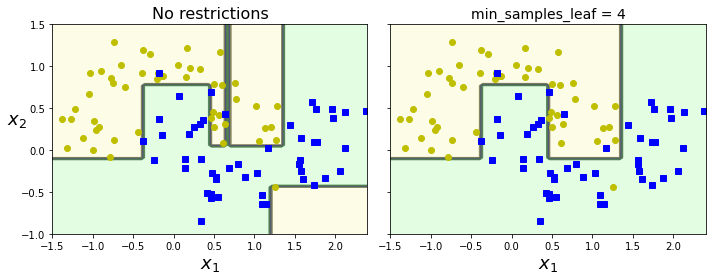

In [229]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")

save_fig("[6-3] min_samples_leaf_plot")
plt.show()

#### NOTE_

제한없이 결정트리를 훈련시키고 불필요한 노드를 가지치기하는 알고리즘도 존재.

순도를 높이는 것이 통계적으로 큰 효과가 없다면 리프노드 바로 위의 노드는 불필요할 수 있음.

대표적으로 $x^2$ 검정같은 통계적 검정을 사용하여 우연히 향상된 것인지 추정함.(귀무가설)

이 확률은 p-값아라 부르며 어떤 임곗값보다 높으면 그 노드는 불필요한 것으로 간주되고 그 자식노드는 삭제됨.

가지치기는 불요한 노드가 모두 없어질 때까지 작동.

## 회귀



In [230]:
# 2차식으로 만든 데이터셋 + 잡음
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [231]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

만들어진 트리 [6-4]

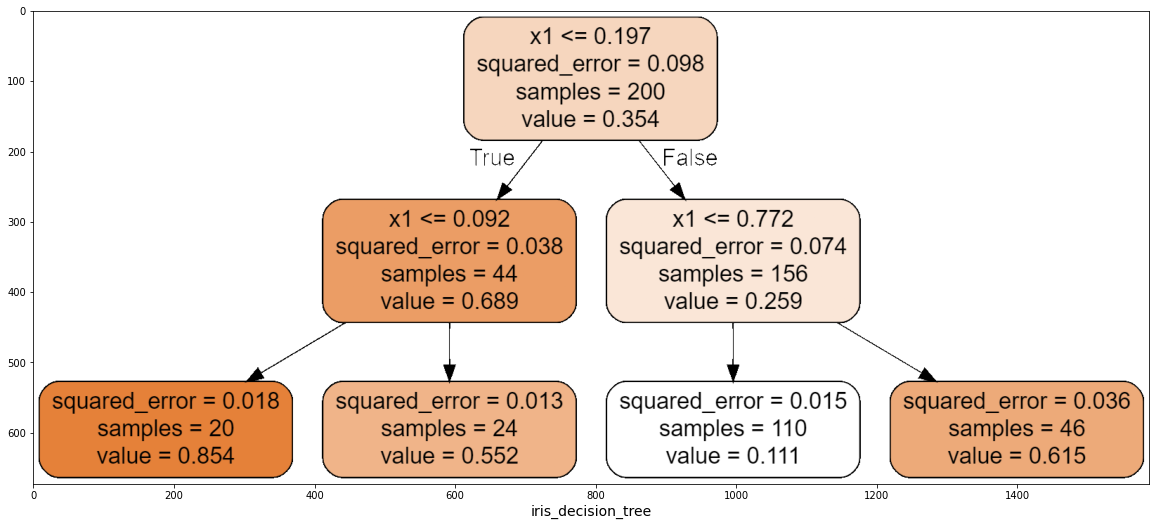

In [232]:
export_graphviz(
        tree_reg1,
        out_file=os.path.join(IMAGES_PATH, "regression_tree.dot"),
        feature_names=["x1"],
        rounded=True,
        filled=True
    )

# Source.from_file(os.path.join(IMAGES_PATH, "regression_tree.dot"))

import matplotlib.image as mpimg

filename = "[6-4] regression_tree.png"
images_path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
show_img = mpimg.imread(os.path.join(images_path, filename))
plt.figure(figsize=(20,40))
plt.axis("off")
plt.imshow(show_img)

앞서 만든 분류트리와 매우 비슷해보임. 주요한 차이는 각 노드에서 클래스를 예측하는 대신

어떤 값을 예측한다는 점. 예를 들어 $x_1=0.6$ 인 샘플의 타깃값을 예측한다고 가정.

루트노드부터 시작해 트리를 순회하면 결국 value=0.111인 리프노드에 도달하게 됨.

이 리프노드에 있는 110개 훈련샘플의 평균타깃값이 예측값이 됨.

이 예측값을 사용해 110개 샘플에 대한 RMSE를 계산하면 0.015가 됨.

이 모델의 예측은 [6-5]의 왼쪽에 나타나 있음. max_depth=3으로 설정하면 오른쪽 그래프와 같은 예측을

얻게 됨. 각 영역의 예측값은 항상 그 영역에 있는 타깃값의 평균이 됨.

알고리즘은 예측값과 가능한 한 많은 샘플이 가까이 있도록 영역을 분할함.

그림 저장: [6-5] tree_regression_plot


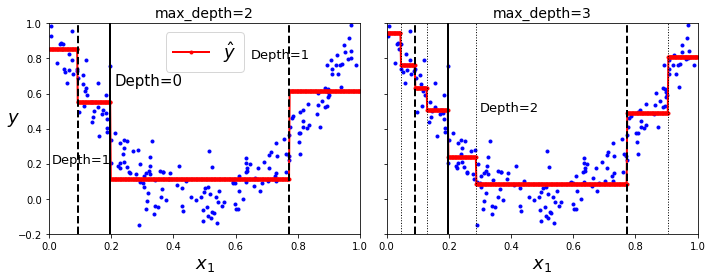

In [233]:
from sklearn.tree import DecisionTreeRegressor

# 2차식으로 만든 데이터셋 + 잡음
'''np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10'''

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

save_fig("[6-5] tree_regression_plot")
plt.show()

CART 알고맂므은 훈련세트를 불순도를 최소화하는 방향으로 분할하는 대신 MSE를 최소화하도록 분할되는 것을

제외하고는 앞서 설명한 것과 거의 비슷하게 작동. [식 6-4]는 알고리즘이 최소화하기 위한 비용함수.

**Equation 6-4: CART cost function for regression**

$
J(k, t_k) = \dfrac{m_{\text{left}}}{m}\text{MSE}_\text{left} + \dfrac{m_{\text{right}}}{m}\text{MSE}_{\text{right}}
$

$
\quad
\text{where} \begin{cases}
\text{MSE}_{\text{node}} = \dfrac{1}{m_{\text{node}}} \sum\limits_{\scriptstyle i \in \text{node}}(\hat{y}_{\text{node}} - y^{(i)})^2\\
\hat{y}_\text{node} = \dfrac{1}{m_{\text{node}}}\sum\limits_{\scriptstyle i \in \text{node}}y^{(i)}
\end{cases}
$

회귀도 마찬가지로 과대적합되기 쉬움. 규제가 없다면 

(즉, 기본 매개변수를 사용할 경우) [6-6]의 왼쪽과 같은 예측을 하게 됨.

min_samples_leaf=10으로 지정하면 [6-6]의 오른쪽 그래프처럼 훨씬 그럴싸한 모델을 만들어줌.

그림 저장: [6-6] tree_regression_regularization_plot


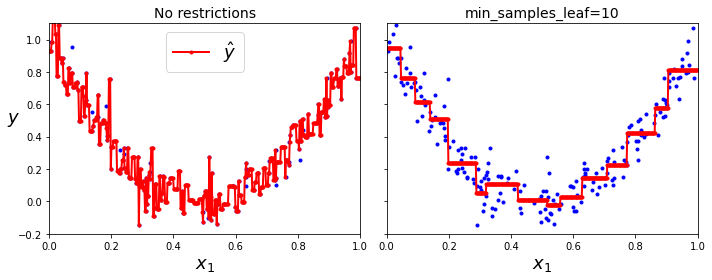

In [234]:
# 2차식으로 만든 데이터셋 + 잡음
'''np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10'''

tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

save_fig("[6-6] tree_regression_regularization_plot")
plt.show()

## 불안정성

결정트리가 많은 장점을 지니고 있다는 것은 알았지만, 몇가지 제한 사항또한 존재함.

결정트리는 계단모양의 결정경계를 만듦(모든 분할은 축에 수직임). 그래서 훈련 세트의 회전에 민감.


[6-7]은 간단한 선형으로 구분될 수 있는 데이터셋을 예로 보여줌. 왼쪽 결정트리는 쉽게 데이터셋을 구분하지만

데이터셋을 45도 회전한 오른쪽 결정트리는 불필요하게 구불구불해짐. 

두 결정트리 모두 훈련세트를 완벽하게 학습하지만 오른쪽 모델은 잘 일반화될 것 같지 않음.

이런 문제를 해결하려면 훈련데이터를 더 좋은 방향으로 회전시키는 PCA기법을 사용하는 것.

그림 저장: [6-7] sensitivity_to_rotation_plot


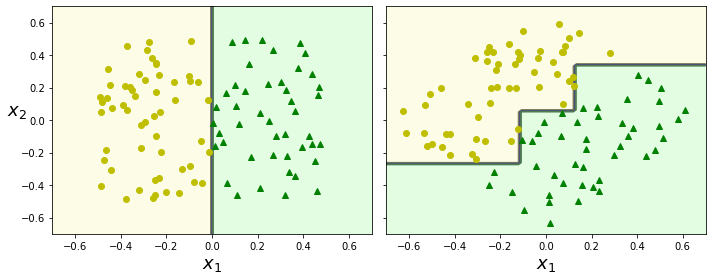

In [235]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.sca(axes[1])
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.ylabel("")

save_fig("[6-7] sensitivity_to_rotation_plot")
plt.show()

결정트리의 주된 문제는 훈련셋에 잇는 작은 변화에도 매우 민감하다는 것.

예를들어 훈련세트에서 가장 넓은 Iris-Versicolor를 제거하고 결정 트리를 훈련시키면 [6-8]과 같은 모델을 얻음.

이전에 만든 결정트리(6-2)와는 매우 다른 모습. 

사실 사이킷런에서 사용하는 훈련 알고리즘은 확률적이기 때문에 (random_state를 지정하지 않으면)

같은 훈련셋에서도 다른 모델을 얻게 됨.

In [236]:
iris = load_iris()
X = iris.data[:, 2:] # 꽃잎 길이와 너비
y = iris.target

그림 저장: [6-8] decision_tree_instability_plot


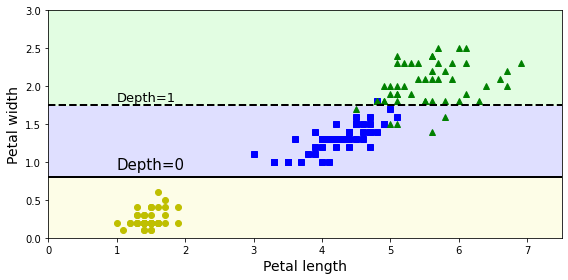

In [237]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X, y, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)

save_fig("[6-8] decision_tree_instability_plot")
plt.show()

다음에 볼 랜덤포레스트는 많은 트리에서 만든 예측을 평균하여 이런 불안정성을 극복가능